# Non circular supplementary analysis
Replicate main results using the "non-circular" activity flow method

In [25]:
import ActflowToolbox as aft
import h5py
import pkg_resources
import numpy as np
import pandas as pd
import pickle
import time
import functions as mf # my functions
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.stats.multitest import multipletests

## global variables
# parcellation
PARC = 'cabn'

# subjects
subj_df = pd.read_csv('subject_list.txt', sep='\t', index_col = 0, header = 0)
subj_list = subj_df.index

# out directories
results_dir = '/projects/f_mc1689_1/ClinicalActFlow/data/results/non-circ/'
figure_dir = '/projects/f_mc1689_1/ClinicalActFlow/docs/figures/non-circ/'

# which connectivity type to use
fc_task = 'multitask-no-scap'
fc_method = 'pc_multregconn_100'

# task to analyze
task = 'scap'

# groups to analyze
groups = ['CTRL','SCHZ']

In [2]:
from scipy import signal
PARC = 'cabn'
OUTPUT_DIR = '/projects/f_mc1689_1/ClinicalActFlow/data/prepro/Output_'+PARC+'/'
task_list = ['rest','taskswitch','bart','stopsignal']
model_task ='24pXaCompCorXVolterra'
model_rest = '24pXaCompCorXVolterra-spikeReg'
zscore=False

def get_multi_timeseries(subj):


    h5f = h5py.File(OUTPUT_DIR + subj + '_GLMOutput.h5','r')
    data = np.zeros((718,1))
    
    for task in task_list:

        # get the right nuisance model
        if task == 'rest':
            model = model_rest
        else:
            model = model_task

        # load the data
        if task == 'rest':
            # load residuals from specific parcellation
            current_data = h5f[task]['nuisanceReg_resid_'+model][:].copy()
        else:
            # get FIR data residuals
            current_data = h5f[task]['FIR']['taskActivity_resid_'+model][:].copy()

        # demean data
        current_data = signal.detrend(current_data,axis=0,type='constant')

        # zscore data
        if zscore:
            current_data = stats.zscore(current_data,axis=0)

        # concatenate data
        data = np.hstack((data,current_data.T))
    h5f.close()

    # remove the initial zero col
    data = np.delete(data,0,axis=1)
    
    return data

# Non circular activity flow
see https://colelab.github.io/ActflowToolbox/HCP_example.html

In [3]:
#Load dictionary listing which parcels to exclude for each target
numnodes=718
networkdefdir = pkg_resources.resource_filename('ActflowToolbox', 'network_definitions/')
inputfilename = networkdefdir+'parcels_to_remove_indices_cortexsubcortex_data.h5'
h5f = h5py.File(inputfilename,'r')
parcels_to_remove={}
for parcelInt in range(numnodes):
    outname1 = 'parcels_to_remove_indices'+'/'+str(parcelInt)
    parcels_to_remove[parcelInt] = h5f[outname1][:].copy()
h5f.close()

In [ ]:
run_non_circ = 0

if run_non_circ:
    #Calculate multiple-regression FC, excluding parcels within 10 mm of each target parcel
    for s,subj in enumerate(subj_list[1:130]):
        print(s,subj)
        start = time.time()
        data = get_multi_timeseries(subj)

        fc=aft.connectivity_estimation.pc_multregconn(data,n_components=100,
                                                                     parcelstoexclude_bytarget=parcels_to_remove)

        # save data
        h5f = h5py.File(results_dir + subj +'_non-circFC.h5','a')

        try:
            h5f.create_dataset('/fc',data=fc)
        except:
            del h5f['/fc']
            h5f.create_dataset('/fc',data=fc)

        h5f.close()
    print('\t',np.round((time.time() - start)/60),'minutes')

else:
    # load the SZ and HC data seperately
    hc_fc = np.zeros((718,718,93))
    for s,subj in enumerate(subj_list[0:93]):
        h5f = h5py.File(results_dir + subj +'_non-circFC.h5','r')
        hc_fc[:,:,s] = h5f['fc'][:]
        h5f.close()
        
    sz_fc = np.zeros((718,718,36))
    for s,subj in enumerate(subj_list[93:129]):
        h5f = h5py.File(results_dir + subj +'_non-circFC.h5','r')
        sz_fc[:,:,s] = h5f['fc'][:]
        h5f.close()

In [13]:
# load the data
# behav
accuracy,reaction_time,_,_,task_labels = mf.load_scan_behaviour(subj_df.index,[task],subj_df['group'].values)

# activity
activity,activity_all = mf.load_activity(subj_df,PARC=PARC,TASKS=[task])
n_roi = activity['scap']['CTRL'].shape[0]

Task| scap Data loaded: 100.0 %


# Run activity flow using the non-circular FC (with actflow toolbox)

In [18]:
# run activity flow using toolbox
res = aft.actflowcomp.actflowtest(activity['scap']['CTRL'], hc_fc)

===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 12 conditions across 718 nodes, p-values based on 93 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.62, t-value vs. 0: 51.27, p-value vs. 0: 1.8461443018835847e-69
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.36
 
Mean MAE (mean absolute error) = 1.55
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html for more info.


In [ ]:
# run activity flow using toolbox
res = aft.actflowcomp.actflowtest(activity['scap']['SCHZ'], sz_fc)

# Run using my commands
(holding out other significant regions from the analysis)

In [19]:
# generate activity flow predictions seperately in each group holding out certain roi
roi_list = [56, 181, 284, 346] 

task = 'scap'
af_file = 'actflow-' + fc_task + '-' + fc_method + '.pickle'

predicted_activity = {}
predicted_activity[task] = {}
actFlowWeights = {}
actFlowWeights[task] = {}

for group in ['CTRL','SCHZ']:
    print('Running act flow in',group)
    
    # use non circular fc
    if group == 'CTRL':
        fc_data = hc_fc
    elif group =='SCHZ':
        fc_data = sz_fc
        
    actPredVector = np.zeros((np.shape(activity[task][group])))
    n_nodes =  np.shape(actPredVector)[0]
    n_conditions = np.shape(actPredVector)[1]
    n_subs = np.shape(actPredVector)[2]
    act_weights_mat = np.zeros((n_nodes,n_nodes,n_conditions,n_subs))

    for condition in range(n_conditions):
        act_data = activity[task][group][:,condition,:].copy()

        for subj in range(np.shape(fc_data)[2]):
            actPredVector[:,condition,subj],act_weights_mat[:,:,condition,subj] = mf.actflowcalc_hold_out_roi(act_data[:,subj],fc_data[:,:,subj],held_out_roi=roi_list)

    predicted_activity[task][group] = actPredVector
    actFlowWeights[task][group] = act_weights_mat
    

Running act flow in CTRL
Running act flow in SCHZ


In [20]:
from scipy.stats import ttest_ind
# do stats on the activity flow predictions
r = {}
MAE = {}
MAPE = {}
Rsqr = {}
for group in ['CTRL','SCHZ']:
    # do the same contrast
    real = np.mean(activity['scap'][group][:,6:12,:],axis=1) - np.mean(activity['scap'][group][:,0:6,:],axis=1)
    pred = np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1)
    
    # do actflow statistics
    r[group] = []
    MAE[group] = []
    MAPE[group] = []
    Rsqr[group] = []
    r[group],rs,MAE[group],MAPE[group],Rsqr[group] = mf.actflow_tests(real,pred,normalise=False)
    
# compare the groups
print('between groups: r t-test')
print('\t',ttest_ind(r['CTRL'],r['SCHZ'],equal_var=False))
print('between groups: MAE t-test')
print('\t',ttest_ind(MAE['CTRL'],MAE['SCHZ'],equal_var=False))
print('between groups: Rsqr t-test')
print('\t',ttest_ind(Rsqr['CTRL'],Rsqr['SCHZ'],equal_var=False))

Mean r across subjs: 0.532 |1samp t: 37.25 p: 0.0
Mean MAE  across subjs: 0.666
Mean MAPE  across subjs: 374.834
Mean R^2  across subjs: 0.268 |1samp t: 15.07 p: 0.0
Mean r across subjs: 0.478 |1samp t: 17.78 p: 0.0
Mean MAE  across subjs: 0.654
Mean MAPE  across subjs: 435.535
Mean R^2  across subjs: 0.192 |1samp t: 5.0 p: 2e-05
between groups: r t-test
	 Ttest_indResult(statistic=1.7839517173364465, pvalue=0.0798628068945824)
between groups: MAE t-test
	 Ttest_indResult(statistic=0.4680858318212692, pvalue=0.6417684683385267)
between groups: Rsqr t-test
	 Ttest_indResult(statistic=1.7899950574576495, pvalue=0.0794263596753079)


In [23]:
# between groups t-test, FDR corrected - replication of the original analysis
x = np.mean(predicted_activity[task]['CTRL'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['CTRL'][:,0:6,:],axis=1)
y = np.mean(predicted_activity[task]['SCHZ'][:,6:12,:],axis=1) - np.mean(predicted_activity[task]['SCHZ'][:,0:6,:],axis=1)

for roi in roi_list:
    display(pg.ttest(x[roi,:],y[roi,:]))

# test accuracy within each roi
r,MAE,MAPE,Rsqr = mf.roi_level_accuracy(activity,predicted_activity,roi_list)
print('Correlation within each roi=',r)
print('MAE within each roi=',MAE)
print('MAPE within each roi=',MAPE)
print('Rsqr within each roi=',Rsqr)

df_roi_metrics = pd.DataFrame()
df_roi_metrics['actflow-full'] = r
df_roi_metrics['metric'] = 'r'

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.958,95.13,two-sided,0.003905,"[-0.53, -0.11]",0.488,9.592,0.695


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.329,75.21,two-sided,0.187817,"[-0.35, 0.07]",0.242,0.455,0.231


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.311,84.92,two-sided,0.001365,"[-0.6, -0.15]",0.572,24.717,0.825


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.253,85.68,two-sided,0.001635,"[-0.52, -0.13]",0.56,21.001,0.809


Correlation within each roi= [0.7708185  0.73923791 0.79533881 0.76835503]
MAE within each roi= [1.0408612  1.3286347  1.0789198  1.02042591]
MAPE within each roi= [ 154.32097321  314.17866835 1020.63380047  288.87159508]
Rsqr within each roi= [0.59341648 0.48409295 0.6308455  0.57342913]


# Plots

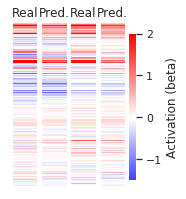

In [29]:
# plot the avg betas
network_order,network_cols,network_def,networks = mf.get_network_info(PARC,subcortical_split=True)
ax_count = 0
fig, axn = plt.subplots(1, 4, sharex=True, sharey=True, figsize=[2,3])

for group in ['CTRL','SCHZ']:
    # do the same contrast
    real = np.mean(activity['scap'][group][:,6:12,:],axis=1) - np.mean(activity['scap'][group][:,0:6,:],axis=1)
    pred = np.mean(predicted_activity['scap'][group][:,6:12,:],axis=1) - np.mean(predicted_activity['scap'][group][:,0:6,:],axis=1)
    
    # do the plot
    datamin = -1.5
    datamax = 2
    data1 = np.mean(real,axis=1)
    data1 = data1[network_order]

    data2 = np.mean(pred,axis=1)
    data2 = data2[network_order]
    

    ax1 = sns.heatmap(data1,ax=axn[ax_count],center=0,cmap='bwr',cbar=False,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax)
    ax1.title.set_text('Real')
    ax_count = ax_count+1
    
    if ax_count==3:
        cbar_ax = fig.add_axes([0.93, .15, .05, .68])
        ax2 = sns.heatmap(data2,ax=axn[ax_count],center=0,cmap='bwr',cbar=True,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax,
                      cbar_ax=cbar_ax,cbar_kws={'label': 'Activation (beta)'})
    else:
        ax2 = sns.heatmap(data2,ax=axn[ax_count],center=0,cmap='bwr',cbar=False,yticklabels=[],xticklabels=[],vmin=datamin,vmax=datamax)
    
    ax2.title.set_text('Pred.')
    ax_count = ax_count+1
    
plt.savefig(figure_dir+'ActFlow-wholebrain-avg-comp.jpeg')
plt.savefig(figure_dir+'ActFlow-wholebrain-avg-comp.svg')

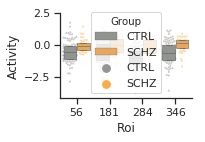

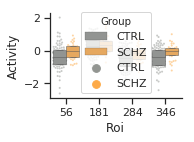

In [36]:
PAL = sns.xkcd_palette(['grey','light orange'])

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

df_plot = pd.DataFrame()
for roi in roi_list:
    for group in ['CTRL','SCHZ']:
        df = pd.DataFrame()
        df['Activity'] = np.mean(activity[task][group][roi,6:12,:],axis=0) - np.mean(activity[task][group][roi,0:6,:],axis=0)
        df['Group'] = group
        df['Roi'] = roi
        df_plot = pd.concat([df_plot,df])
        
plt.figure(figsize=cm2inch(6.0,4.0))      
g = sns.boxplot(y='Activity',x='Roi',hue='Group',data=df_plot,palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(y='Activity',x='Roi',hue='Group',data=df_plot,size=2,palette=PAL,dodge=True,zorder=0,alpha=0.5)
sns.despine()
plt.savefig(figure_dir+'GLM_roi-real.jpeg',dpi=600)
plt.savefig(figure_dir+'GLM_roi-real.svg',dpi=600)
    
df_plot = pd.DataFrame()
for roi in roi_list:
    for group in ['CTRL','SCHZ']:
        df = pd.DataFrame()
        df['Activity'] = np.mean(predicted_activity[task][group][roi,6:12,:],axis=0) - np.mean(predicted_activity[task][group][roi,0:6,:],axis=0)
        df['Group'] = group
        df['Roi'] = roi
        df_plot = pd.concat([df_plot,df])
        
plt.figure(figsize=cm2inch(6.0,4.0))      
g = sns.boxplot(y='Activity',x='Roi',hue='Group',data=df_plot,palette=PAL,linewidth=0.5,fliersize=0,whis=0,zorder=1)
sns.swarmplot(y='Activity',x='Roi',hue='Group',data=df_plot,size=2,palette=PAL,dodge=True,zorder=0,alpha=0.5)
sns.despine()
plt.savefig(figure_dir+'GLM_roi-pred.jpeg',dpi=600)
plt.savefig(figure_dir+'GLM_roi-pred.svg',dpi=600)